# PostgreSQL Vector Database with pgvector

This notebook demonstrates how to use PostgreSQL with the pgvector extension for vector similarity search. PostgreSQL offers a unique advantage: combining vector search with traditional SQL capabilities.

## Overview

While FAISS excels at pure vector operations, PostgreSQL with pgvector provides:
- ACID transactions for vector operations
- SQL integration (JOINs, filters, aggregations)
- Mature ecosystem (backups, monitoring, tooling)
- Existing infrastructure leverage

## Prerequisites

Before running this notebook, ensure PostgreSQL with pgvector is running:

```bash
# Start PostgreSQL with pgvector
task postgres-start

# Or using docker-compose directly
docker-compose up -d postgres-vector
```

## Setup and Imports

In [1]:
# Import required libraries
import os
import psycopg2
from psycopg2.extras import RealDictCursor
import numpy as np
from sentence_transformers import SentenceTransformer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from dotenv import load_dotenv
import json

# Load environment variables
load_dotenv()

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Connect to PostgreSQL

In [2]:
# Database connection parameters
conn_params = {
    'host': os.getenv('POSTGRES_HOST', 'localhost'),
    'port': os.getenv('POSTGRES_PORT', '5433'),
    'dbname': os.getenv('POSTGRES_DB', 'vector_demo'),
    'user': os.getenv('POSTGRES_USER', 'postgres'),
    'password': os.getenv('POSTGRES_PASSWORD', 'postgres')
}

# Connect to PostgreSQL
try:
    conn = psycopg2.connect(**conn_params)
    cursor = conn.cursor(cursor_factory=RealDictCursor)
    print("✅ Connected to PostgreSQL")
    
    # Register pgvector extension
    from pgvector.psycopg2 import register_vector
    register_vector(conn)
    print("✅ pgvector extension registered")
    
except Exception as e:
    print(f"❌ Connection failed: {e}")
    print("\nPlease ensure PostgreSQL is running:")
    print("  task postgres-start")

✅ Connected to PostgreSQL
✅ pgvector extension registered


## Enable pgvector Extension

In [3]:
# Enable pgvector extension
cursor.execute("CREATE EXTENSION IF NOT EXISTS vector")
conn.commit()
print("✅ pgvector extension enabled")

# Check version
cursor.execute("SELECT extversion FROM pg_extension WHERE extname = 'vector'")
version = cursor.fetchone()
print(f"pgvector version: {version['extversion'] if version else 'Not found'}")

✅ pgvector extension enabled
pgvector version: 0.8.0


## Load Embedding Model

In [4]:
# Load sentence transformer model
print("Loading embedding model...")
model = SentenceTransformer('all-MiniLM-L6-v2')
dimension = model.get_sentence_embedding_dimension()
print(f"✅ Model loaded (dimension: {dimension})")

Loading embedding model...
✅ Model loaded (dimension: 384)


## Create Vector-Enabled Table

In [5]:
# Drop existing table if exists
cursor.execute("DROP TABLE IF EXISTS documents CASCADE")

# Create table with vector column
create_table_sql = f"""
CREATE TABLE documents (
    id SERIAL PRIMARY KEY,
    content TEXT NOT NULL,
    embedding vector({dimension}),
    metadata JSONB,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)
"""

cursor.execute(create_table_sql)
conn.commit()
print("✅ Table 'documents' created")

# Show table structure
cursor.execute("""
    SELECT column_name, data_type 
    FROM information_schema.columns 
    WHERE table_name = 'documents'
""")
columns = cursor.fetchall()
print("\nTable structure:")
for col in columns:
    print(f"  - {col['column_name']}: {col['data_type']}")

✅ Table 'documents' created

Table structure:
  - id: integer
  - embedding: USER-DEFINED
  - metadata: jsonb
  - created_at: timestamp without time zone
  - content: text


## Insert Sample Documents

In [21]:
# Sample documents - let's add more detailed content for better FTS results
documents = [
    "PostgreSQL is a powerful, open source relational database system with ACID compliance.",
    "Vector databases enable semantic search using embeddings for similarity matching.",
    "pgvector adds vector similarity search capabilities to PostgreSQL database.",
    "Machine learning models generate embeddings for text data analysis and search.",
    "Semantic search understands meaning and context, not just keywords or exact matches.",
    "ACID transactions ensure data consistency in databases. ACID stands for Atomicity, Consistency, Isolation, and Durability.",
    "SQL queries can combine vector search with filters for hybrid search approaches.",
    "Embeddings capture semantic relationships between words and phrases in vector space.",
    "PostgreSQL supports JSON data types natively with JSONB for efficient storage and querying.",
    "Vector similarity search finds related documents efficiently using cosine distance metrics.",
    "Full-text search in PostgreSQL uses tsvector for tokenized, stemmed text indexing.",
    "Database consistency is maintained through ACID properties and transaction isolation levels.",
    "JSON support in PostgreSQL includes operators for querying nested JSON structures.",
    "Hybrid search combines keyword matching with semantic understanding for better results.",
    "PostgreSQL extensions like pgvector enable advanced search capabilities beyond traditional SQL."
]

# Generate embeddings
print("Generating embeddings...")
embeddings = model.encode(documents, show_progress_bar=True)

# Clear existing documents
cursor.execute("DELETE FROM documents")
conn.commit()

# Insert documents with embeddings
insert_sql = """
INSERT INTO documents (content, embedding, metadata)
VALUES (%s, %s, %s)
"""

for i, (doc, emb) in enumerate(zip(documents, embeddings)):
    metadata = {
        'length': len(doc),
        'word_count': len(doc.split()),
        'category': 'database' if any(word in doc.lower() for word in ['database', 'postgresql', 'sql', 'acid']) else 'ml'
    }
    cursor.execute(insert_sql, (doc, emb.tolist(), json.dumps(metadata)))

conn.commit()
print(f"\n✅ Inserted {len(documents)} documents with richer content")

Generating embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


✅ Inserted 15 documents with richer content


## Basic Semantic Search

In [7]:
# Function to perform semantic search
def semantic_search(query, limit=5):
    # Generate query embedding
    query_embedding = model.encode(query)
    
    # Search using cosine similarity
    search_sql = """
    SELECT 
        id,
        content,
        1 - (embedding <=> %s::vector) AS similarity,
        metadata
    FROM documents
    ORDER BY embedding <=> %s::vector
    LIMIT %s
    """
    
    cursor.execute(search_sql, (query_embedding.tolist(), query_embedding.tolist(), limit))
    return cursor.fetchall()

# Test semantic search
query = "How to search for similar text?"
print(f"🔍 Query: '{query}'\n")

results = semantic_search(query)
for i, result in enumerate(results, 1):
    print(f"{i}. {result['content'][:70]}...")
    print(f"   Similarity: {result['similarity']:.3f}")
    print(f"   Category: {result['metadata']['category']}\n")

🔍 Query: 'How to search for similar text?'

1. Vector similarity search finds related documents efficiently using cos...
   Similarity: 0.586
   Category: ml

2. Full-text search in PostgreSQL uses tsvector for tokenized, stemmed te...
   Similarity: 0.529
   Category: database

3. Hybrid search combines keyword matching with semantic understanding fo...
   Similarity: 0.497
   Category: ml

4. Vector databases enable semantic search using embeddings for similarit...
   Similarity: 0.472
   Category: database

5. Semantic search understands meaning and context, not just keywords or ...
   Similarity: 0.442
   Category: ml



# Analyze query performance
print("🔧 Query Performance Analysis\n")

# Explain query plan
explain_sql = """
EXPLAIN (ANALYZE, BUFFERS)
SELECT content
FROM documents
ORDER BY embedding <=> %s::vector
LIMIT 5
"""

query_emb = model.encode("test query")
cursor.execute(explain_sql, (query_emb.tolist(),))

print("Query Execution Plan:")
for row in cursor.fetchall():
    print(row['QUERY PLAN'])

In [8]:
# Generate more test data
print("Generating larger dataset...")
np.random.seed(42)

# Create synthetic documents
categories = ['tech', 'health', 'finance', 'education', 'travel']
templates = {
    'tech': ['software', 'hardware', 'programming', 'AI', 'data'],
    'health': ['wellness', 'medicine', 'fitness', 'nutrition', 'mental'],
    'finance': ['investment', 'banking', 'budget', 'savings', 'credit'],
    'education': ['learning', 'teaching', 'courses', 'degree', 'skills'],
    'travel': ['vacation', 'destination', 'flights', 'hotels', 'adventure']
}

large_docs = []
for i in range(1000):
    cat = np.random.choice(categories)
    word = np.random.choice(templates[cat])
    large_docs.append(f"Document about {word} in {cat} category #{i}")

# Generate embeddings in batches
large_embeddings = model.encode(large_docs, batch_size=32, show_progress_bar=True)

# Insert into a new table for testing
cursor.execute("DROP TABLE IF EXISTS documents_test CASCADE")
cursor.execute(f"""
CREATE TABLE documents_test (
    id SERIAL PRIMARY KEY,
    content TEXT,
    embedding vector({dimension})
)
""")

# Bulk insert
print("\nInserting documents...")
for doc, emb in zip(large_docs, large_embeddings):
    cursor.execute(
        "INSERT INTO documents_test (content, embedding) VALUES (%s, %s)",
        (doc, emb.tolist())
    )
conn.commit()
print(f"✅ Inserted {len(large_docs)} documents")

Generating larger dataset...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]


Inserting documents...
✅ Inserted 1000 documents


In [9]:
# Test different index types
index_tests = [
    {"name": "No Index", "create_sql": None},
    {
        "name": "IVFFlat", 
        "create_sql": "CREATE INDEX idx_ivfflat ON documents_test USING ivfflat (embedding vector_cosine_ops) WITH (lists = 50)"
    },
    {
        "name": "HNSW", 
        "create_sql": "CREATE INDEX idx_hnsw ON documents_test USING hnsw (embedding vector_cosine_ops) WITH (m = 16, ef_construction = 64)"
    }
]

results = []
test_queries = ["AI and machine learning", "financial planning", "health and wellness"]

for test in index_tests:
    print(f"\nTesting {test['name']}...")
    
    # Drop all indexes
    cursor.execute("DROP INDEX IF EXISTS idx_ivfflat")
    cursor.execute("DROP INDEX IF EXISTS idx_hnsw")
    
    # Create index if specified
    if test['create_sql']:
        start = time.time()
        cursor.execute(test['create_sql'])
        conn.commit()
        create_time = time.time() - start
        print(f"  Index created in {create_time:.3f}s")
    else:
        create_time = 0
    
    # Benchmark searches
    search_times = []
    for query in test_queries:
        query_emb = model.encode(query)
        
        start = time.time()
        cursor.execute("""
            SELECT content FROM documents_test
            ORDER BY embedding <=> %s::vector
            LIMIT 5
        """, (query_emb.tolist(),))
        _ = cursor.fetchall()
        search_times.append(time.time() - start)
    
    avg_search = np.mean(search_times)
    results.append({
        'Index Type': test['name'],
        'Create Time (s)': create_time,
        'Avg Search (ms)': avg_search * 1000
    })
    print(f"  Avg search time: {avg_search * 1000:.2f}ms")

# Display results
results_df = pd.DataFrame(results)
display(results_df)


Testing No Index...
  Avg search time: 4.20ms

Testing IVFFlat...
  Index created in 0.023s
  Avg search time: 1.50ms

Testing HNSW...
  Index created in 0.131s
  Avg search time: 1.48ms


,Index Type,Create Time (s),Avg Search (ms)
0,No Index,0.000000,4.198472
1,IVFFlat,0.022663,1.496633
2,HNSW,0.130854,1.481295


## Visualize Performance Comparison

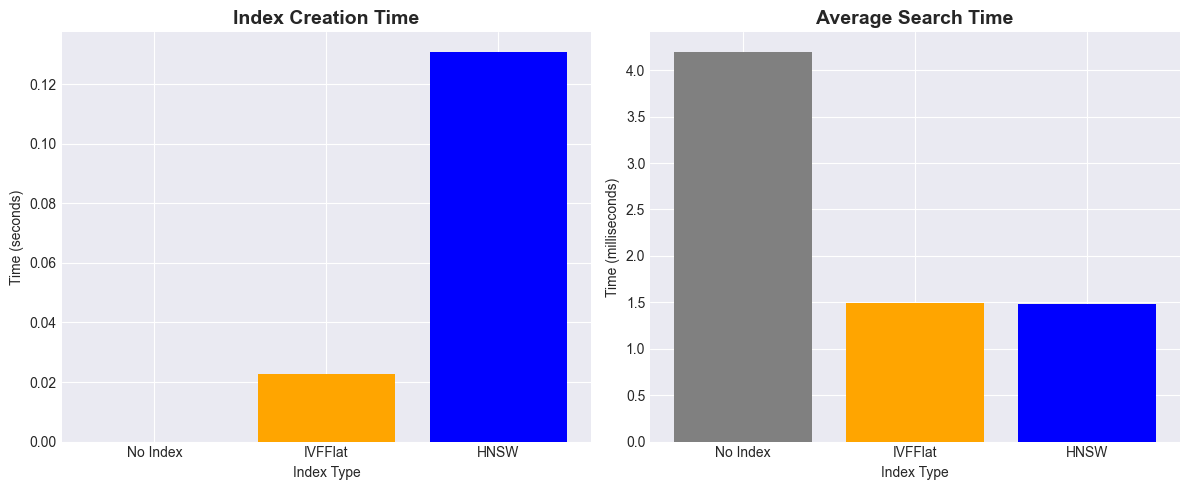

In [10]:
# Create performance visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Index creation time
ax1.bar(results_df['Index Type'], results_df['Create Time (s)'], color=['gray', 'orange', 'blue'])
ax1.set_title('Index Creation Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Time (seconds)')
ax1.set_xlabel('Index Type')

# Search performance
ax2.bar(results_df['Index Type'], results_df['Avg Search (ms)'], color=['gray', 'orange', 'blue'])
ax2.set_title('Average Search Time', fontsize=14, fontweight='bold')
ax2.set_ylabel('Time (milliseconds)')
ax2.set_xlabel('Index Type')

plt.tight_layout()
plt.show()

## Hybrid Search: Combining Vector and SQL

In [11]:
# Demonstrate hybrid search capabilities
print("🔍 Hybrid Search Example\n")

# Query 1: Vector search with metadata filter
query = "database systems"
query_emb = model.encode(query)

hybrid_sql = """
SELECT 
    content,
    1 - (embedding <=> %s::vector) AS similarity,
    metadata->>'category' AS category,
    metadata->>'word_count' AS word_count
FROM documents
WHERE metadata->>'category' = 'database'
ORDER BY embedding <=> %s::vector
LIMIT 3
"""

cursor.execute(hybrid_sql, (query_emb.tolist(), query_emb.tolist()))
results = cursor.fetchall()

print(f"Query: '{query}' (filtered by category='database')\n")
for i, result in enumerate(results, 1):
    print(f"{i}. {result['content'][:60]}...")
    print(f"   Similarity: {result['similarity']:.3f}")
    print(f"   Words: {result['word_count']}\n")

🔍 Hybrid Search Example

Query: 'database systems' (filtered by category='database')

1. PostgreSQL is a powerful, open source relational database sy...
   Similarity: 0.628
   Words: 12

2. Database consistency is maintained through ACID properties a...
   Similarity: 0.547
   Words: 11

3. ACID transactions ensure data consistency in databases. ACID...
   Similarity: 0.430
   Words: 15



In [12]:
# Query 2: Combine with aggregation
print("\n📊 Aggregated Analysis\n")

agg_sql = """
WITH similarity_scores AS (
    SELECT 
        metadata->>'category' AS category,
        1 - (embedding <=> %s::vector) AS similarity
    FROM documents
)
SELECT 
    category,
    COUNT(*) as doc_count,
    AVG(similarity) as avg_similarity,
    MAX(similarity) as max_similarity
FROM similarity_scores
GROUP BY category
ORDER BY avg_similarity DESC
"""

query = "machine learning and AI"
query_emb = model.encode(query)

cursor.execute(agg_sql, (query_emb.tolist(),))
results = cursor.fetchall()

print(f"Category analysis for query: '{query}'\n")
for result in results:
    print(f"Category: {result['category']}")
    print(f"  Documents: {result['doc_count']}")
    print(f"  Avg Similarity: {result['avg_similarity']:.3f}")
    print(f"  Max Similarity: {result['max_similarity']:.3f}\n")


📊 Aggregated Analysis

Category analysis for query: 'machine learning and AI'

Category: ml
  Documents: 5
  Avg Similarity: 0.229
  Max Similarity: 0.420

Category: database
  Documents: 10
  Avg Similarity: 0.099
  Max Similarity: 0.229



## Advanced Features

### 1. Similarity Threshold Search

In [13]:
# Find documents above similarity threshold
query = "vector similarity search"
query_emb = model.encode(query)
threshold = 0.7

threshold_sql = """
SELECT 
    content,
    1 - (embedding <=> %s::vector) AS similarity
FROM documents
WHERE 1 - (embedding <=> %s::vector) > %s
ORDER BY similarity DESC
"""

cursor.execute(threshold_sql, (query_emb.tolist(), query_emb.tolist(), threshold))
results = cursor.fetchall()

print(f"🎯 Documents with similarity > {threshold} for '{query}':\n")
for result in results:
    print(f"• {result['content']}")
    print(f"  Similarity: {result['similarity']:.3f}\n")

🎯 Documents with similarity > 0.7 for 'vector similarity search':

• Vector similarity search finds related documents efficiently using cosine distance metrics.
  Similarity: 0.756

• Vector databases enable semantic search using embeddings for similarity matching.
  Similarity: 0.728



### 2. Distance Metrics Comparison

In [14]:
# Compare different distance metrics
query = "PostgreSQL database"
query_emb = model.encode(query)

metrics_sql = """
SELECT 
    content,
    embedding <=> %s::vector AS cosine_distance,
    embedding <-> %s::vector AS l2_distance,
    (embedding <#> %s::vector) * -1 AS inner_product
FROM documents
ORDER BY embedding <=> %s::vector
LIMIT 3
"""

cursor.execute(
    metrics_sql, 
    (query_emb.tolist(), query_emb.tolist(), query_emb.tolist(), query_emb.tolist())
)
results = cursor.fetchall()

print(f"📏 Distance Metrics for '{query}':\n")
for i, result in enumerate(results, 1):
    print(f"{i}. {result['content'][:50]}...")
    print(f"   Cosine Distance: {result['cosine_distance']:.4f}")
    print(f"   L2 Distance: {result['l2_distance']:.4f}")
    print(f"   Inner Product: {result['inner_product']:.4f}\n")

📏 Distance Metrics for 'PostgreSQL database':

1. PostgreSQL is a powerful, open source relational d...
   Cosine Distance: 0.3253
   L2 Distance: 0.8066
   Inner Product: 0.6747

2. PostgreSQL supports JSON data types natively with ...
   Cosine Distance: 0.4703
   L2 Distance: 0.9699
   Inner Product: 0.5297

3. pgvector adds vector similarity search capabilitie...
   Cosine Distance: 0.4971
   L2 Distance: 0.9971
   Inner Product: 0.5029



## Performance Tips

In [15]:
# Analyze query performance
print("🔧 Query Performance Analysis\n")

# Note: \timing is a psql command and cannot be used in psycopg2
# Instead, we'll use EXPLAIN ANALYZE to see performance details

# Explain query plan
explain_sql = """
EXPLAIN (ANALYZE, BUFFERS)
SELECT content
FROM documents
ORDER BY embedding <=> %s::vector
LIMIT 5
"""

query_emb = model.encode("test query")
cursor.execute(explain_sql, (query_emb.tolist(),))

print("Query Execution Plan:")
for row in cursor.fetchall():
    print(row['QUERY PLAN'])

🔧 Query Performance Analysis

Query Execution Plan:
Limit  (cost=27.47..27.48 rows=5 width=40) (actual time=0.044..0.046 rows=5 loops=1)
  Buffers: shared hit=4
  ->  Sort  (cost=27.47..28.97 rows=600 width=40) (actual time=0.042..0.043 rows=5 loops=1)
        Sort Key: ((embedding <=> '[0.06836465,0.061701227,-0.006391845,0.08266664,-0.07825048,0.026623234,0.13128832,0.041390337,-0.019488232,-0.027117653,0.0887235,-0.10274626,0.050741456,-0.071399555,-0.009377467,-0.039309133,0.028911654,-0.01044704,-0.024713451,-0.035506554,-0.040939823,-0.009934676,-0.026162473,0.057978578,-0.0005227391,0.007676561,0.013899053,-0.001718884,0.044623125,-0.059028137,-0.03797688,0.037778124,-0.03326178,0.07162018,0.09725358,-0.0826359,0.027587669,-0.014187348,0.018265922,-0.0027843933,-0.024240935,-0.11488299,0.08516509,-0.016772319,-0.0063312817,0.06521774,-0.05800921,0.096605726,-0.014203127,-0.0068077715,-0.09896558,-0.015062192,-0.078298755,-0.0355551,-0.00822689,-0.01371346,-0.0762865,-0.030440861

## RAG Integration Example

In [16]:
def rag_search(question, context_limit=3):
    """
    Retrieval-Augmented Generation using pgvector
    """
    # Retrieve relevant documents
    query_emb = model.encode(question)
    
    rag_sql = """
    SELECT 
        content,
        1 - (embedding <=> %s::vector) AS similarity
    FROM documents
    ORDER BY embedding <=> %s::vector
    LIMIT %s
    """
    
    cursor.execute(rag_sql, (query_emb.tolist(), query_emb.tolist(), context_limit))
    results = cursor.fetchall()
    
    # Build context
    context_parts = []
    for i, result in enumerate(results, 1):
        context_parts.append(f"{i}. {result['content']} (Relevance: {result['similarity']:.2%})")
    
    context = "\n".join(context_parts)
    
    # Format for LLM
    prompt = f"""
Based on the following context, answer the question.

Context:
{context}

Question: {question}

Answer: [This would be sent to an LLM for generation]
"""
    
    return prompt, results

# Test RAG search
question = "How does pgvector help with semantic search?"
prompt, docs = rag_search(question)

print("🤖 RAG Example\n")
print(f"Question: {question}\n")
print("Retrieved Documents:")
for doc in docs:
    print(f"- {doc['content'][:80]}...")
    print(f"  Relevance: {doc['similarity']:.2%}\n")

print("\nGenerated Prompt (truncated):")
print(prompt[:500] + "...")

🤖 RAG Example

Question: How does pgvector help with semantic search?

Retrieved Documents:
- pgvector adds vector similarity search capabilities to PostgreSQL database....
  Relevance: 71.83%

- Semantic search understands meaning and context, not just keywords or exact matc...
  Relevance: 60.40%

- PostgreSQL extensions like pgvector enable advanced search capabilities beyond t...
  Relevance: 59.63%


Generated Prompt (truncated):

Based on the following context, answer the question.

Context:
1. pgvector adds vector similarity search capabilities to PostgreSQL database. (Relevance: 71.83%)
2. Semantic search understands meaning and context, not just keywords or exact matches. (Relevance: 60.40%)
3. PostgreSQL extensions like pgvector enable advanced search capabilities beyond traditional SQL. (Relevance: 59.63%)

Question: How does pgvector help with semantic search?

Answer: [This would be sent to an LLM for generation]...


### Key Takeaways: When to Use Each Approach

Based on our experiments, here's when to use each search method:

#### Use Pure Vector Search When:
- Queries are conceptual or abstract
- Users may use different terminology than documents
- You need to find semantically related content
- Cross-language search is required

#### Use Full-Text Search When:
- Exact phrase matching is critical (error codes, technical terms)
- You need to find specific keywords or identifiers
- Users know the exact terminology
- Performance is critical and queries are simple

#### Use Hybrid Search When:
- You need the best of both worlds
- Query patterns are mixed (technical + conceptual)
- Building a production search system
- Implementing RAG systems that need both precision and recall

### Summary

PostgreSQL's combination of pgvector and Full-Text Search provides a powerful, enterprise-ready solution for modern search applications. By understanding when and how to combine these approaches, you can build search systems that excel at both semantic understanding and precise matching.

The hybrid approach we've demonstrated here forms the foundation for production-grade RAG systems, recommendation engines, and intelligent search applications that can handle the full spectrum of user queries.

In [17]:
# Add Full-Text Search column to our documents table
print("🔍 Adding Full-Text Search capabilities...\n")

# First, let's check if the column already exists
cursor.execute("""
    SELECT column_name 
    FROM information_schema.columns 
    WHERE table_name = 'documents' AND column_name = 'content_tsv'
""")
column_exists = cursor.fetchone()

if not column_exists:
    # Add tsvector column for FTS
    alter_table_sql = """
    ALTER TABLE documents
    ADD COLUMN content_tsv tsvector
    GENERATED ALWAYS AS (to_tsvector('english', content)) STORED;
    """
    
    try:
        cursor.execute(alter_table_sql)
        conn.commit()
        print("✅ Added tsvector column for full-text search")
    except Exception as e:
        print(f"Error adding column: {e}")
        conn.rollback()
else:
    print("✅ tsvector column already exists")
    
    # If column exists but might have NULL values, let's force an update
    # First drop the column
    cursor.execute("ALTER TABLE documents DROP COLUMN IF EXISTS content_tsv")
    conn.commit()
    
    # Then recreate it
    cursor.execute("""
        ALTER TABLE documents
        ADD COLUMN content_tsv tsvector
        GENERATED ALWAYS AS (to_tsvector('english', content)) STORED
    """)
    conn.commit()
    print("✅ Recreated tsvector column to ensure it's populated")

# Create GIN index for fast text search
create_index_sql = """
CREATE INDEX IF NOT EXISTS idx_documents_content_tsv
ON documents USING GIN (content_tsv);
"""

cursor.execute(create_index_sql)
conn.commit()
print("✅ Created/verified GIN index for full-text search")

# Verify the column was added and has data
cursor.execute("""
    SELECT 
        COUNT(*) as total_docs,
        COUNT(content_tsv) as docs_with_tsv,
        COUNT(*) FILTER (WHERE content_tsv IS NOT NULL) as non_null_tsv
    FROM documents
""")
stats = cursor.fetchone()
print(f"\n📊 FTS Statistics:")
print(f"  Total documents: {stats['total_docs']}")
print(f"  Documents with tsvector: {stats['docs_with_tsv']}")
print(f"  Non-null tsvectors: {stats['non_null_tsv']}")

# Show what to_tsvector does
print("\n📚 Understanding tsvector transformation:")
test_text = "PostgreSQL is running queries with amazing performance"
cursor.execute("SELECT to_tsvector('english', %s) as tsv", (test_text,))
result = cursor.fetchone()
print(f"\nOriginal: '{test_text}'")
print(f"tsvector: {result['tsv']}")
print("\nNotice how:")
print("- 'running' becomes 'run' (stemming)")
print("- 'is' and 'with' are removed (stop words)")
print("- Words are stored with positions for ranking")

🔍 Adding Full-Text Search capabilities...

✅ Added tsvector column for full-text search
✅ Created/verified GIN index for full-text search

📊 FTS Statistics:
  Total documents: 15
  Documents with tsvector: 15
  Non-null tsvectors: 15

📚 Understanding tsvector transformation:

Original: 'PostgreSQL is running queries with amazing performance'
tsvector: 'amaz':6 'perform':7 'postgresql':1 'queri':4 'run':3

Notice how:
- 'running' becomes 'run' (stemming)
- 'is' and 'with' are removed (stop words)
- Words are stored with positions for ranking


### Reconnect to Database (if needed)

Run this cell if you get connection errors:

In [18]:
# Let's debug why FTS scores are 0
print("🔍 Debugging Full-Text Search\n")

# Check if tsvector column has data
cursor.execute("SELECT id, content, content_tsv FROM documents LIMIT 5")
results = cursor.fetchall()

print("Sample documents with tsvector:")
for result in results:
    print(f"\nID: {result['id']}")
    print(f"Content: {result['content'][:60]}...")
    print(f"TSVector: {result['content_tsv']}")

# Test different queries
test_queries = ["ACID", "JSON", "PostgreSQL", "database", "semantic search"]

print("\n\n📊 Testing FTS queries:")
for query in test_queries:
    print(f"\n--- Query: '{query}' ---")
    
    # Show how the query is processed
    cursor.execute("SELECT plainto_tsquery('english', %s) as tsquery", (query,))
    tsquery = cursor.fetchone()
    print(f"TSQuery: {tsquery['tsquery']}")
    
    # Test the FTS match
    cursor.execute("""
        SELECT content, ts_rank_cd(content_tsv, plainto_tsquery('english', %s)) as rank
        FROM documents
        WHERE content_tsv @@ plainto_tsquery('english', %s)
        ORDER BY rank DESC
        LIMIT 3
    """, (query, query))
    
    results = cursor.fetchall()
    if results:
        for i, result in enumerate(results, 1):
            print(f"{i}. {result['content'][:60]}... (Rank: {result['rank']:.3f})")
    else:
        print("  No matches found!")
        
# Let's also check a direct match
print("\n\n🔍 Direct FTS test with 'ACID':")
cursor.execute("""
    SELECT content, content_tsv, 
           content_tsv @@ to_tsquery('english', 'acid') as matches,
           ts_rank_cd(content_tsv, to_tsquery('english', 'acid')) as rank
    FROM documents
    WHERE content ILIKE '%ACID%'
""")
results = cursor.fetchall()
for result in results:
    print(f"\nContent: {result['content'][:80]}...")
    print(f"Matches: {result['matches']}")
    print(f"Rank: {result['rank']}")
    print(f"TSVector preview: {str(result['content_tsv'])[:100]}...")

🔍 Debugging Full-Text Search

Sample documents with tsvector:

ID: 1
Content: PostgreSQL is a powerful, open source relational database sy...
TSVector: 'acid':11 'complianc':12 'databas':8 'open':5 'postgresql':1 'power':4 'relat':7 'sourc':6 'system':9

ID: 2
Content: Vector databases enable semantic search using embeddings for...
TSVector: 'databas':2 'embed':7 'enabl':3 'match':10 'search':5 'semant':4 'similar':9 'use':6 'vector':1

ID: 3
Content: pgvector adds vector similarity search capabilities to Postg...
TSVector: 'add':2 'capabl':6 'databas':9 'pgvector':1 'postgresql':8 'search':5 'similar':4 'vector':3

ID: 4
Content: Machine learning models generate embeddings for text data an...
TSVector: 'analysi':9 'data':8 'embed':5 'generat':4 'learn':2 'machin':1 'model':3 'search':11 'text':7

ID: 5
Content: Semantic search understands meaning and context, not just ke...
TSVector: 'context':6 'exact':11 'keyword':9 'match':12 'mean':4 'search':2 'semant':1 'understand':3


📊 Testin

### Debug FTS Issues

In [19]:
# Add Full-Text Search column to our documents table
print("🔍 Adding Full-Text Search capabilities...\n")

# First, let's check if the column already exists
cursor.execute("""
    SELECT column_name 
    FROM information_schema.columns 
    WHERE table_name = 'documents' AND column_name = 'content_tsv'
""")
column_exists = cursor.fetchone()

if not column_exists:
    # Add tsvector column for FTS
    alter_table_sql = """
    ALTER TABLE documents
    ADD COLUMN content_tsv tsvector
    GENERATED ALWAYS AS (to_tsvector('english', content)) STORED;
    """
    
    try:
        cursor.execute(alter_table_sql)
        conn.commit()
        print("✅ Added tsvector column for full-text search")
    except Exception as e:
        print(f"Error adding column: {e}")
        conn.rollback()
else:
    print("✅ tsvector column already exists")

# Create GIN index for fast text search
create_index_sql = """
CREATE INDEX IF NOT EXISTS idx_documents_content_tsv
ON documents USING GIN (content_tsv);
"""

cursor.execute(create_index_sql)
conn.commit()
print("✅ Created/verified GIN index for full-text search")

# Verify the column was added
cursor.execute("""
    SELECT column_name, data_type 
    FROM information_schema.columns 
    WHERE table_name = 'documents'
    ORDER BY ordinal_position
""")
columns = cursor.fetchall()
print("\nCurrent table structure:")
for col in columns:
    print(f"  - {col['column_name']}: {col['data_type']}")

# Show what to_tsvector does
print("\n📚 Understanding tsvector transformation:")
test_text = "PostgreSQL is running queries with amazing performance"
cursor.execute("SELECT to_tsvector('english', %s) as tsv", (test_text,))
result = cursor.fetchone()
print(f"\nOriginal: '{test_text}'")
print(f"tsvector: {result['tsv']}")
print("\nNotice how:")
print("- 'running' becomes 'run' (stemming)")
print("- 'is' and 'with' are removed (stop words)")
print("- Words are stored with positions for ranking")

🔍 Adding Full-Text Search capabilities...

✅ tsvector column already exists
✅ Created/verified GIN index for full-text search

Current table structure:
  - id: integer
  - content: text
  - embedding: USER-DEFINED
  - metadata: jsonb
  - created_at: timestamp without time zone
  - content_tsv: tsvector

📚 Understanding tsvector transformation:

Original: 'PostgreSQL is running queries with amazing performance'
tsvector: 'amaz':6 'perform':7 'postgresql':1 'queri':4 'run':3

Notice how:
- 'running' becomes 'run' (stemming)
- 'is' and 'with' are removed (stop words)
- Words are stored with positions for ranking


### Performance Comparison: Vector vs FTS vs Hybrid

Let's analyze the performance characteristics of each approach:

In [22]:
def hybrid_rag_search(question, context_limit=3, adaptive_weights=True):
    """
    Enhanced RAG using hybrid search for better retrieval
    
    Args:
        question: User's question
        context_limit: Number of documents to retrieve
        adaptive_weights: Automatically adjust weights based on query type
    """
    # Determine optimal weights based on query characteristics
    if adaptive_weights:
        # Simple heuristic: technical queries favor FTS, conceptual favor vector
        technical_terms = ['ACID', 'SQL', 'JSON', 'PostgreSQL', 'index', 'query']
        query_words = question.lower().split()
        
        # Check for technical terms
        has_technical = any(term.lower() in question.lower() for term in technical_terms)
        
        # Adjust weights
        if has_technical:
            vector_weight, fts_weight = 0.4, 0.6
            print(f"🔧 Detected technical query - favoring FTS")
        elif len(query_words) <= 3:
            vector_weight, fts_weight = 0.3, 0.7
            print(f"📝 Short query - favoring exact matches")
        else:
            vector_weight, fts_weight = 0.7, 0.3
            print(f"💭 Conceptual query - favoring semantic search")
    else:
        vector_weight, fts_weight = 0.6, 0.4
    
    print(f"\n🤖 Hybrid RAG Search")
    print(f"Question: {question}")
    print(f"Weights: Vector={vector_weight}, FTS={fts_weight}\n")
    
    # Generate query embedding
    query_emb = model.encode(question)
    
    # Enhanced hybrid search with metadata
    rag_sql = """
    WITH vector_scores AS (
        SELECT 
            id,
            content,
            metadata,
            1 - (embedding <=> %s::vector) AS vector_similarity
        FROM documents
    ),
    fts_scores AS (
        SELECT 
            id,
            ts_rank_cd(content_tsv, plainto_tsquery('english', %s)) AS fts_rank,
            ts_headline('english', content, plainto_tsquery('english', %s),
                       'StartSel=**, StopSel=**') AS headline
        FROM documents
        WHERE content_tsv @@ plainto_tsquery('english', %s)
    ),
    combined AS (
        SELECT 
            v.id,
            v.content,
            v.metadata,
            v.vector_similarity,
            COALESCE(f.fts_rank, 0) AS fts_rank,
            f.headline,
            (%s * v.vector_similarity) + 
            (%s * LEAST(COALESCE(f.fts_rank, 0) * 10, 1)) AS hybrid_score
        FROM vector_scores v
        LEFT JOIN fts_scores f ON v.id = f.id
    )
    SELECT *
    FROM combined
    ORDER BY hybrid_score DESC
    LIMIT %s
    """
    
    cursor.execute(rag_sql, 
                   (query_emb.tolist(), question, question, question, 
                    vector_weight, fts_weight, context_limit))
    results = cursor.fetchall()
    
    # Build enhanced context
    context_parts = []
    for i, result in enumerate(results, 1):
        # Include highlighted text if available
        if result['headline']:
            content = result['headline']
        else:
            content = result['content']
        
        context_parts.append(
            f"{i}. {content}\n"
            f"   [Category: {result['metadata'].get('category', 'unknown')}, "
            f"Relevance: {result['hybrid_score']:.2%}]"
        )
    
    context = "\n\n".join(context_parts)
    
    # Create prompt
    prompt = f"""Based on the following context from a PostgreSQL documentation, answer the question.

Context:
{context}

Question: {question}

Please provide a comprehensive answer based on the context above. If the context doesn't contain enough information, indicate what's missing.

Answer:"""
    
    print("Retrieved Documents:")
    for i, result in enumerate(results, 1):
        print(f"\n{i}. {result['content'][:80]}...")
        print(f"   Vector Score: {result['vector_similarity']:.3f}")
        print(f"   FTS Score: {result['fts_rank']:.3f}")
        print(f"   Hybrid Score: {result['hybrid_score']:.3f}")
        if result['headline'] and '**' in result['headline']:
            print(f"   Matched Terms: {result['headline']}")
    
    return prompt, results

# Test enhanced RAG with different question types
test_questions = [
    "What are ACID properties in PostgreSQL?",
    "How does semantic search work?",
    "Tell me about JSON support",
]

for question in test_questions:
    print("\n" + "="*80)
    prompt, docs = hybrid_rag_search(question, context_limit=3)
    print("\n📄 Generated Prompt Preview:")
    print(prompt[:600] + "...")


🔧 Detected technical query - favoring FTS

🤖 Hybrid RAG Search
Question: What are ACID properties in PostgreSQL?
Weights: Vector=0.4, FTS=0.6

Retrieved Documents:

1. PostgreSQL is a powerful, open source relational database system with ACID compl...
   Vector Score: 0.632
   FTS Score: 0.000
   Hybrid Score: 0.253

2. ACID transactions ensure data consistency in databases. ACID stands for Atomicit...
   Vector Score: 0.617
   FTS Score: 0.000
   Hybrid Score: 0.247

3. Database consistency is maintained through ACID properties and transaction isola...
   Vector Score: 0.505
   FTS Score: 0.000
   Hybrid Score: 0.202

📄 Generated Prompt Preview:
Based on the following context from a PostgreSQL documentation, answer the question.

Context:
1. PostgreSQL is a powerful, open source relational database system with ACID compliance.
   [Category: database, Relevance: 25.29%]

2. ACID transactions ensure data consistency in databases. ACID stands for Atomicity, Consistency, Isolation, and D

### Advanced Hybrid RAG with FTS

Let's enhance our RAG system to use hybrid search for better retrieval:

In [23]:
def hybrid_search(query, vector_weight=0.7, fts_weight=0.3, limit=5):
    """
    Hybrid search combining vector similarity and full-text search
    
    Args:
        query: Search query
        vector_weight: Weight for semantic similarity (0-1)
        fts_weight: Weight for full-text search (0-1)
        limit: Number of results to return
    """
    print(f"\n🔍 Hybrid Search: '{query}'")
    print(f"   Weights: Vector={vector_weight}, FTS={fts_weight}\n")
    
    # Generate query embedding
    query_emb = model.encode(query)
    
    # Hybrid search SQL combining both scores
    hybrid_sql = """
    WITH vector_scores AS (
        SELECT 
            id,
            content,
            1 - (embedding <=> %s::vector) AS vector_similarity
        FROM documents
    ),
    fts_scores AS (
        SELECT 
            id,
            ts_rank_cd(content_tsv, plainto_tsquery('english', %s)) AS fts_rank
        FROM documents
        WHERE content_tsv @@ plainto_tsquery('english', %s)
    ),
    combined_scores AS (
        SELECT 
            v.id,
            v.content,
            v.vector_similarity,
            COALESCE(f.fts_rank, 0) AS fts_rank,
            -- Normalize FTS rank to 0-1 range (approximate)
            CASE 
                WHEN COALESCE(f.fts_rank, 0) = 0 THEN 0
                ELSE LEAST(COALESCE(f.fts_rank, 0) * 10, 1)
            END AS fts_normalized,
            -- Calculate hybrid score
            (%s * v.vector_similarity) + 
            (%s * LEAST(COALESCE(f.fts_rank, 0) * 10, 1)) AS hybrid_score
        FROM vector_scores v
        LEFT JOIN fts_scores f ON v.id = f.id
    )
    SELECT 
        content,
        vector_similarity,
        fts_normalized,
        hybrid_score
    FROM combined_scores
    ORDER BY hybrid_score DESC
    LIMIT %s
    """
    
    cursor.execute(hybrid_sql, 
                   (query_emb.tolist(), query, query, vector_weight, fts_weight, limit))
    results = cursor.fetchall()
    
    for i, result in enumerate(results, 1):
        print(f"{i}. {result['content'][:60]}...")
        print(f"   Vector Score: {result['vector_similarity']:.3f}")
        print(f"   FTS Score: {result['fts_normalized']:.3f}")
        print(f"   Hybrid Score: {result['hybrid_score']:.3f}")
        print()
    
    return results

# Test hybrid search with different weight configurations
test_configs = [
    ("semantic understanding", 0.8, 0.2),  # Favor semantic
    ("ACID transactions", 0.5, 0.5),       # Balanced
    ("PostgreSQL", 0.3, 0.7),              # Favor exact match
]

for query, vec_w, fts_w in test_configs:
    hybrid_search(query, vec_w, fts_w, limit=3)
    print("="*60)


🔍 Hybrid Search: 'semantic understanding'
   Weights: Vector=0.8, FTS=0.2

1. Semantic search understands meaning and context, not just ke...
   Vector Score: 0.589
   FTS Score: 0.500
   Hybrid Score: 0.571

2. Hybrid search combines keyword matching with semantic unders...
   Vector Score: 0.447
   FTS Score: 1.000
   Hybrid Score: 0.557

3. Embeddings capture semantic relationships between words and ...
   Vector Score: 0.454
   FTS Score: 0.000
   Hybrid Score: 0.364


🔍 Hybrid Search: 'ACID transactions'
   Weights: Vector=0.5, FTS=0.5

1. ACID transactions ensure data consistency in databases. ACID...
   Vector Score: 0.686
   FTS Score: 1.000
   Hybrid Score: 0.843

2. Database consistency is maintained through ACID properties a...
   Vector Score: 0.494
   FTS Score: 0.333
   Hybrid Score: 0.413

3. PostgreSQL is a powerful, open source relational database sy...
   Vector Score: 0.401
   FTS Score: 0.000
   Hybrid Score: 0.200


🔍 Hybrid Search: 'PostgreSQL'
   Weights: Vector

### Hybrid Search: Combining FTS and Vector Search

Now let's create a hybrid search that combines the best of both worlds. This approach uses:
- **Vector search** for semantic understanding
- **Full-text search** for exact matches
- **Weighted scoring** to balance both approaches

In [24]:
# Compare Vector Search and Full-Text Search
def compare_search_methods(query):
    """Compare results from vector search and FTS"""
    print(f"\n🔍 Query: '{query}'\n")
    
    # 1. Vector Search
    print("=== VECTOR SEARCH (Semantic) ===")
    query_emb = model.encode(query)
    
    vector_sql = """
    SELECT 
        content,
        1 - (embedding <=> %s::vector) AS similarity
    FROM documents
    ORDER BY embedding <=> %s::vector
    LIMIT 3
    """
    
    cursor.execute(vector_sql, (query_emb.tolist(), query_emb.tolist()))
    vector_results = cursor.fetchall()
    
    for i, result in enumerate(vector_results, 1):
        print(f"{i}. {result['content'][:60]}...")
        print(f"   Similarity: {result['similarity']:.3f}")
    
    # 2. Full-Text Search
    print("\n=== FULL-TEXT SEARCH (Lexical) ===")
    
    # Convert query to tsquery
    fts_sql = """
    SELECT 
        content,
        ts_rank_cd(content_tsv, plainto_tsquery('english', %s)) AS rank
    FROM documents
    WHERE content_tsv @@ plainto_tsquery('english', %s)
    ORDER BY rank DESC
    LIMIT 3
    """
    
    cursor.execute(fts_sql, (query, query))
    fts_results = cursor.fetchall()
    
    if fts_results:
        for i, result in enumerate(fts_results, 1):
            print(f"{i}. {result['content'][:60]}...")
            print(f"   Rank: {result['rank']:.3f}")
    else:
        print("   No exact matches found")
    
    return vector_results, fts_results

# Test with different query types
test_queries = [
    "How does PostgreSQL handle ACID transactions?",  # Technical query
    "database consistency",  # Concept query
    "JSON data types",  # Exact feature query
]

for query in test_queries:
    compare_search_methods(query)
    print("\n" + "="*60)


🔍 Query: 'How does PostgreSQL handle ACID transactions?'

=== VECTOR SEARCH (Semantic) ===
1. ACID transactions ensure data consistency in databases. ACID...
   Similarity: 0.651
2. PostgreSQL is a powerful, open source relational database sy...
   Similarity: 0.612
3. Database consistency is maintained through ACID properties a...
   Similarity: 0.524

=== FULL-TEXT SEARCH (Lexical) ===
   No exact matches found


🔍 Query: 'database consistency'

=== VECTOR SEARCH (Semantic) ===
1. Database consistency is maintained through ACID properties a...
   Similarity: 0.760
2. ACID transactions ensure data consistency in databases. ACID...
   Similarity: 0.520
3. PostgreSQL is a powerful, open source relational database sy...
   Similarity: 0.447

=== FULL-TEXT SEARCH (Lexical) ===
1. Database consistency is maintained through ACID properties a...
   Rank: 0.100
2. ACID transactions ensure data consistency in databases. ACID...
   Rank: 0.070


🔍 Query: 'JSON data types'

=== VECTOR SEARCH (S

### Comparing Vector Search vs. Full-Text Search

Let's see how each approach handles different types of queries:

In [25]:
# Add Full-Text Search column to our documents table
print("🔍 Adding Full-Text Search capabilities...\n")

# Add tsvector column for FTS
alter_table_sql = """
ALTER TABLE documents
ADD COLUMN content_tsv tsvector
GENERATED ALWAYS AS (to_tsvector('english', content)) STORED;
"""

try:
    cursor.execute(alter_table_sql)
    conn.commit()
    print("✅ Added tsvector column for full-text search")
except Exception as e:
    print(f"Column might already exist: {e}")
    conn.rollback()

# Create GIN index for fast text search
create_index_sql = """
CREATE INDEX IF NOT EXISTS idx_documents_content_tsv
ON documents USING GIN (content_tsv);
"""

cursor.execute(create_index_sql)
conn.commit()
print("✅ Created GIN index for full-text search")

# Show what to_tsvector does
print("\n📚 Understanding tsvector transformation:")
test_text = "PostgreSQL is running queries with amazing performance"
cursor.execute("SELECT to_tsvector('english', %s) as tsv", (test_text,))
result = cursor.fetchone()
print(f"\nOriginal: '{test_text}'")
print(f"tsvector: {result['tsv']}")
print("\nNotice how:")
print("- 'running' becomes 'run' (stemming)")
print("- 'is' and 'with' are removed (stop words)")
print("- Words are stored with positions for ranking")

🔍 Adding Full-Text Search capabilities...

Column might already exist: column "content_tsv" of relation "documents" already exists

✅ Created GIN index for full-text search

📚 Understanding tsvector transformation:

Original: 'PostgreSQL is running queries with amazing performance'
tsvector: 'amaz':6 'perform':7 'postgresql':1 'queri':4 'run':3

Notice how:
- 'running' becomes 'run' (stemming)
- 'is' and 'with' are removed (stop words)
- Words are stored with positions for ranking


# Performance comparison
import time

# First, ensure we have the FTS column
try:
    # Quick test to ensure FTS column exists
    cursor.execute("SELECT content_tsv FROM documents LIMIT 1")
    cursor.fetchone()
except Exception as e:
    print(f"⚠️ FTS column missing. Please run the 'Add Full-Text Search column' cell above first.")
    print(f"Error: {e}")
    raise

print("⚡ Performance Comparison: Vector vs FTS vs Hybrid\n")

# Test queries covering different scenarios
perf_test_queries = [
    "PostgreSQL ACID",           # Short, technical
    "database consistency",      # Medium, conceptual
    "How to ensure data integrity in distributed systems",  # Long, complex
]

results_summary = []

for query in perf_test_queries:
    print(f"\nTesting: '{query}'")
    print("-" * 60)
    
    query_emb = model.encode(query)
    
    # 1. Vector Search Performance
    start_time = time.time()
    cursor.execute("""
        SELECT content, 1 - (embedding <=> %s::vector) AS score
        FROM documents
        ORDER BY embedding <=> %s::vector
        LIMIT 3
    """, (query_emb.tolist(), query_emb.tolist()))
    vector_results = cursor.fetchall()
    vector_time = (time.time() - start_time) * 1000
    
    # 2. FTS Performance
    start_time = time.time()
    cursor.execute("""
        SELECT content, ts_rank_cd(content_tsv, plainto_tsquery('english', %s)) AS score
        FROM documents
        WHERE content_tsv @@ plainto_tsquery('english', %s)
        ORDER BY score DESC
        LIMIT 3
    """, (query, query))
    fts_results = cursor.fetchall()
    fts_time = (time.time() - start_time) * 1000
    
    # 3. Hybrid Search Performance
    start_time = time.time()
    cursor.execute("""
        WITH vector_scores AS (
            SELECT id, content, 1 - (embedding <=> %s::vector) AS vec_score
            FROM documents
        ),
        fts_scores AS (
            SELECT id, ts_rank_cd(content_tsv, plainto_tsquery('english', %s)) AS fts_score
            FROM documents
            WHERE content_tsv @@ plainto_tsquery('english', %s)
        )
        SELECT v.content, 
               (0.6 * v.vec_score + 0.4 * COALESCE(f.fts_score * 10, 0)) AS score
        FROM vector_scores v
        LEFT JOIN fts_scores f ON v.id = f.id
        ORDER BY score DESC
        LIMIT 3
    """, (query_emb.tolist(), query, query))
    hybrid_results = cursor.fetchall()
    hybrid_time = (time.time() - start_time) * 1000
    
    # Summary
    results_summary.append({
        'Query': query[:30] + '...' if len(query) > 30 else query,
        'Vector Time (ms)': f"{vector_time:.2f}",
        'FTS Time (ms)': f"{fts_time:.2f}",
        'Hybrid Time (ms)': f"{hybrid_time:.2f}",
        'Vector Top Result': vector_results[0]['content'][:40] + '...' if vector_results else 'None',
        'FTS Top Result': fts_results[0]['content'][:40] + '...' if fts_results else 'None',
    })
    
    print(f"Vector Search: {vector_time:.2f}ms - Top: {vector_results[0]['content'][:50] if vector_results else 'None'}...")
    print(f"FTS Search: {fts_time:.2f}ms - Top: {fts_results[0]['content'][:50] if fts_results else 'None'}...")
    print(f"Hybrid Search: {hybrid_time:.2f}ms - Top: {hybrid_results[0]['content'][:50] if hybrid_results else 'None'}...")

# Display summary table
print("\n\n📊 Performance Summary")
print("=" * 80)
summary_df = pd.DataFrame(results_summary)
display(summary_df)

## Cleanup

In [ ]:
# Close database connection
cursor.close()
conn.close()
print("✅ Database connection closed")

print("\n📚 Summary:")
print("- pgvector adds vector operations to PostgreSQL")
print("- Supports multiple index types (IVFFlat, HNSW)")
print("- Enables hybrid queries combining vectors and SQL")
print("- Perfect for RAG and enterprise search applications")
print("\nTo stop PostgreSQL: task postgres-stop")

## Conclusion

PostgreSQL with pgvector provides a powerful combination:

1. **ACID Compliance**: Full transactional support for vector operations
2. **SQL Integration**: Combine semantic search with filters, joins, and aggregations
3. **Mature Ecosystem**: Leverage existing PostgreSQL tools and infrastructure
4. **Flexibility**: Choose between different index types based on your needs

### When to Use pgvector vs FAISS:

**Use pgvector when:**
- You need ACID transactions
- You want to combine vector search with SQL queries
- You have existing PostgreSQL infrastructure
- You need full CRUD operations on vectors

**Use FAISS when:**
- You need maximum search performance
- You're working with billions of vectors
- You don't need transactional guarantees
- You want more index options and GPU support

### Next Steps:

1. Experiment with different index parameters
2. Try larger datasets to see performance differences
3. Implement a full RAG system with an LLM
4. Explore partitioning for very large tables
5. Set up monitoring and query optimization

For more information, see the [pgvector documentation](https://github.com/pgvector/pgvector).